In [1]:
from tokenizers import BertWordPieceTokenizer, normalizers
import multiprocessing
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
import time
import tqdm
import string
import mmap
import os
import glob
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
np.random.seed(seed=1)
torch.manual_seed(1)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
CONTEXT_SIZE = 4
EMBEDDING_DIM = 512
files = [name for name in glob.glob('data/archive (2)/arwiki_books_shards/content/sharded/*.txt')] 
np.random.shuffle(files)
vocab_path = 'data/archive (2)/ar_bert32k-vocab.txt'
tokenizer = BertWordPieceTokenizer(vocab_path,strip_accents=False)
max_length=2*CONTEXT_SIZE+1

# building Word2Vec from scratch

In [2]:
class SkipGramDataset(torch.utils.data.IterableDataset):
    def __init__(self, files,context_size):
        super(SkipGramDataset).__init__()
        self.files=files
        self.context_size=context_size
        self.max_length=2*context_size+1
        self.translator=str.maketrans('', '', string.punctuation+'،؟')
        self.chunk_size=8192


    
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        for i, file in enumerate(self.files):
            if i%worker_info.num_workers==worker_info.id:
                with open(file, 'r', encoding='utf-8') as f:
                    mm = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)

                    text=mm.read(self.chunk_size)
                    while(text):
                        #cut up to whitespace
                        last_word=text.rfind(b' ')
                        if last_word ==-1:
                            text=mm.read(self.chunk_size)
                            continue
                        
                        mm.seek(mm.tell()-(len(text)-last_word)+1)
                        
                        text=text[:last_word].decode('utf-8', 'ignore')

                        tokenized_sent = tokenizer.encode(text.translate(self.translator) ,add_special_tokens = False)
                        # if len(tokenized_sent)<self.max_length:
                        #     continue

                        ids=tokenized_sent.ids
                        np.random.shuffle(ids)
                        ids=torch.tensor(ids, dtype= torch.int)      

                        yield ids[[i for i in range(self.max_length) if i!=self.context_size]], ids[self.context_size].long()
                                
                        for chunk in tokenized_sent.overflowing:
                            # if len(chunk)<self.max_length:
                            #     continue
                            ids=chunk.ids
                            np.random.shuffle(ids)
                            ids=torch.tensor(ids, dtype= torch.int)   
                            yield ids[[i for i in range(self.max_length) if i!=self.context_size]], ids[self.context_size].long()
                        
                        text=mm.read(self.chunk_size)
                        

                    mm.close()

       
tokenizer.enable_truncation(max_length=max_length)
tokenizer.enable_padding(length=max_length)
batch_size = 4096
train_data = SkipGramDataset(files, CONTEXT_SIZE)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=multiprocessing.cpu_count()-4)

In [17]:
it=iter(trainloader)
inp, out=next(it)
print(tokenizer.decode_batch(inp.numpy())[9:10],'\ntarget:', tokenizer.decode(out.numpy()[9:10]))

['##يار على على العراق بخت قبض ثم و'] 
target: استولى


In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(2*context_size*embedding_dim, context_size*embedding_dim)
        self.linear2 = nn.Linear(context_size*embedding_dim, 2*embedding_dim)
        self.linear2_1 = nn.Linear(2*embedding_dim, embedding_dim)
        self.linear3 = nn.Linear(embedding_dim, vocab_size)


    def forward(self, inputs):
        embeds = self.embeddings(inputs).reshape(len(inputs),-1) # (batch, sentence len, EMBID_DIM) -> (batch, len*EMBID_DIM)
        out = F.relu(self.linear1(embeds))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear2_1(out))
        out = self.linear3(out)
        
        return out

class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)
        #self.linear2 = nn.Linear(embedding_dim, embedding_dim)
        # self.linear2_1 = nn.Linear(2*embedding_dim, embedding_dim)
        # self.linear3 = nn.Linear(embedding_dim, vocab_size)


    def forward(self, inputs):
        embeds = self.embeddings(inputs).reshape(-1,EMBEDDING_DIM) # (batch, sentence len, EMBID_DIM) -> (batch, len*EMBID_DIM)
        out = F.relu(self.linear1(embeds))

            
        
        return out

least_loss=float('inf')

word2vec = SkipGram(tokenizer.get_vocab_size(), EMBEDDING_DIM, CONTEXT_SIZE)
loss_fun=nn.CrossEntropyLoss()
# word2vec = nn.Embedding(tokenizer.get_vocab_size(), EMBEDDING_DIM)
# embedding= nn.Embedding(tokenizer.get_vocab_size(), EMBEDDING_DIM)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
word2vec=word2vec.to(device)
# embedding=embedding.to(device)
# optimizer = torch.optim.SGD([{"params":word2vec.parameters(), 'params':embedding.parameters()}], lr=0.01*(0.5)**0)
optimizer = torch.optim.SGD(word2vec.parameters(), lr=0.01*(0.5)**0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.6)
# word2vec.load_state_dict(torch.load(f'{CONTEXT_SIZE}_{EMBEDDING_DIM}_vocab64_best_word2vec.pt'))
losses = []

In [ ]:
for epoch in range(12):
    total_loss = 0
    total_num=0
    for context, target in tqdm.tqdm(trainloader):

        context, target=context.to(device), target.to(device)
        word2vec.zero_grad()
        # embedding.zero_grad()

        # context = word2vec(context)
        # target = embedding(target)


        # loss = - F.logsigmoid(torch.mean(context@target.T))
        predictions= word2vec(context)
        loss= loss_fun(predictions, target)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_num += 1
        
    
    if least_loss >loss.item() :
        least_loss=loss.item()
        torch.save(word2vec.state_dict(),f'checkpoints/{CONTEXT_SIZE}_{EMBEDDING_DIM}_vocab32_best_word2vec.pt')

    total_loss/=total_num

    print(f'Epoch:{epoch+1} | train loss:{total_loss} | lr:{scheduler.get_last_lr()}')
    print('-------------------------------------------------------------------------------------------')
    scheduler.step()
    losses.append(total_loss)
    

4257it [05:00, 14.18it/s]


Epoch:1 | train loss:9.430450815815082 | lr:[0.01]
-------------------------------------------------------------------------------------------


4257it [05:01, 14.12it/s]


Epoch:2 | train loss:8.815110688481724 | lr:[0.01]
-------------------------------------------------------------------------------------------


4257it [05:04, 14.00it/s]


Epoch:3 | train loss:8.66821293879037 | lr:[0.01]
-------------------------------------------------------------------------------------------


4257it [05:02, 14.07it/s]


Epoch:4 | train loss:8.598709809995745 | lr:[0.006]
-------------------------------------------------------------------------------------------


4257it [05:02, 14.07it/s]


Epoch:5 | train loss:8.562991486039273 | lr:[0.006]
-------------------------------------------------------------------------------------------


4257it [05:03, 14.03it/s]


Epoch:6 | train loss:8.533311611110122 | lr:[0.006]
-------------------------------------------------------------------------------------------


4257it [05:00, 14.15it/s]


Epoch:7 | train loss:8.512742042317479 | lr:[0.0036]
-------------------------------------------------------------------------------------------


4257it [05:03, 14.03it/s]


Epoch:8 | train loss:8.50319526608292 | lr:[0.0036]
-------------------------------------------------------------------------------------------


4257it [05:01, 14.11it/s]


Epoch:9 | train loss:8.491207898937258 | lr:[0.0036]
-------------------------------------------------------------------------------------------


4257it [05:03, 14.05it/s]


Epoch:10 | train loss:8.48397021140183 | lr:[0.00216]
-------------------------------------------------------------------------------------------


4257it [05:02, 14.06it/s]


Epoch:11 | train loss:8.475752739215194 | lr:[0.00216]
-------------------------------------------------------------------------------------------


830it [00:57, 14.50it/s]


KeyboardInterrupt: 

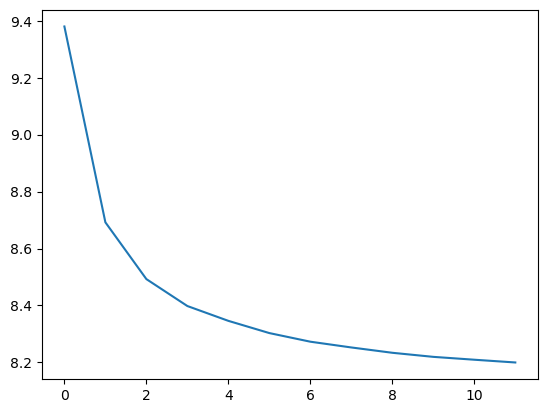

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
torch.save(word2vec.embeddings.state_dict(), f'checkpoints/gramEmbed_{CONTEXT_SIZE}_{EMBEDDING_DIM}_64k.pt')

In [ ]:
# torch.save(word2vec.embeddings.state_dict(), 'context150_64k_gramEmbed.pt')
#torch.save(embedding.state_dict(), 'target150_64k_gramEmbed.pt')

In [ ]:
tokenizer.no_padding()
tok=tokenizer.encode('التطورات', add_special_tokens=False)
embedding=nn.Embedding(tokenizer.get_vocab_size(),EMBEDDING_DIM)
embedding.load_state_dict(torch.load(f'checkpoints/gramEmbed_{CONTEXT_SIZE}_{EMBEDDING_DIM}_64k.pt'))
lo=F.cosine_similarity(embedding.weight , embedding(torch.tensor(tok.ids)), dim=-1)
topk=lo.topk(15,sorted=True)
[(tokenizer.id_to_token(idx), sim.item())  for (sim,idx) in zip(*topk)]

[('التطورات', 0.9999999403953552),
 ('##ئر،', 0.3717387914657593),
 ('كلوريد', 0.341731458902359),
 ('دورة', 0.33476167917251587),
 ('وعندئذ', 0.32477977871894836),
 ('ورجاله', 0.3037056624889374),
 ('الياف', 0.29998016357421875),
 ('الأصبحي', 0.2958613634109497),
 ('اعتراضا', 0.2872800827026367),
 ('للنمو', 0.28694573044776917),
 ('بالحاجة', 0.2852295935153961),
 ('أرجع', 0.28469306230545044),
 ('تفع', 0.2837426960468292),
 ('المحصنة', 0.2833469808101654),
 ('بالعنف', 0.28251659870147705)]

# using gensim

Here’s the revised README with two parts: 

---

# Arabic Language Modeling Comparison

This repository focuses on comparing different Arabic language modeling architectures and creating high-quality word embeddings. It uses the Arabic Wikipedia dataset (6.1 GB) for training.

---

## 1. Embedding Notebook

The notebook includes two approaches for generating word embeddings for Arabic text:

1. **Custom Skip-Gram Model:**
   - Built using PyTorch with a focus on flexible tokenization and training pipelines.
   - Negative sampling and multi-layer architecture for refining embeddings.

2. **Gensim Word2Vec:**
   - Pre-built functionalities for efficient embedding generation.
   - Preferred for its superior performance and reduced computation time.

### Key Notes:
- Arabic tokenization is handled via the BERT WordPiece tokenizer.
- Gensim embeddings were ultimately adopted for better quality and sampling.

---

## 2. Models Implemented

This section describes four Arabic language models with ~14.7M parameters for fair comparison:

1. **N-gram Model**
   - Bigram (N=2) with basic smoothing.
   - Serves as a baseline traditional statistical approach.

2. **LSTM-based RNN**
   - 7-layer architecture with word2vec embeddings.
   - Uses shared embedding layers initialized with pre-trained vectors.

3. **Transformer with Flash Attention**
   - 6 transformer layers with Flash Attention for efficiency.
   - Expansion ratio: 2.66.

4. **Mamba State Space Model (SSM)**
   - 6 Mamba layers with a state dimension of 64.
   - Convolution width: 4, expansion factor: 3.

---

Let me know if further adjustments are needed!

In [2]:
class SkipGramDataset(torch.utils.data.IterableDataset):
    def __init__(self, files):
        super(SkipGramDataset, self).__init__()
        self.files = files
        self.translator = str.maketrans('', '', string.punctuation+'،؟')
        self.chunk_size = 8192

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            # Single-process data loading, no need to split the workload
            num_workers = 1
            worker_id = 0
        else:
            # Multiprocess data loading, split workload
            num_workers = worker_info.num_workers
            worker_id = worker_info.id

        # Calculate the total number of files and split the file list
        num_files = len(self.files)
        per_worker = int(np.ceil(num_files / float(num_workers)))
        start_index = worker_id * per_worker
        end_index = min(start_index + per_worker, num_files)
        worker_files = self.files[start_index:end_index]

        for file in worker_files:
            with open(file, 'r', encoding='utf-8') as f:
                mm = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
                text = mm.read(self.chunk_size)
                while text:
                    # Cut up to last sentence
                    last_word = text.rfind(b'.')
                    if last_word == -1:
                        text = mm.read(self.chunk_size)
                        continue

                    mm.seek(mm.tell() - (len(text) - last_word) + 1)
                    
                    text = text[:last_word].decode('utf-8', 'ignore')
                    tokenized_sent = tokenizer.encode(text.translate(self.translator), add_special_tokens=False)
                    yield tokenized_sent.tokens
                            
                    text = mm.read(self.chunk_size)

                mm.close()



In [3]:
class MonitorCallback(CallbackAny2Vec):
    def __init__(self):
        pass
        

    def on_epoch_end(self, model):
        print("Model loss:", model.get_latest_training_loss())  # print loss

dataset=SkipGramDataset(files=files)
loader = torch.utils.data.DataLoader(dataset, batch_size=None, num_workers=multiprocessing.cpu_count()-2)
monitor = MonitorCallback()
model = Word2Vec(loader, vector_size=EMBEDDING_DIM, window=CONTEXT_SIZE,sg=0, min_count=1,negative =CONTEXT_SIZE,
 workers=multiprocessing.cpu_count()-2, epochs = 10,  callbacks=[monitor])


Model loss: 0.0
Model loss: 0.0
Model loss: 0.0
Model loss: 0.0
Model loss: 0.0
Model loss: 0.0
Model loss: 0.0
Model loss: 0.0
Model loss: 0.0
Model loss: 0.0


In [4]:
model.wv.most_similar('التطورات')

[('التغييرات', 0.7684062719345093),
 ('التغيرات', 0.7484496235847473),
 ('الإصلاحات', 0.701462984085083),
 ('الأحداث', 0.6997469663619995),
 ('التقنيات', 0.6673924922943115),
 ('التحديات', 0.6652474999427795),
 ('النظريات', 0.660948634147644),
 ('الاضطرابات', 0.654200553894043),
 ('المحاولات', 0.6535345315933228),
 ('الأبحاث', 0.6521376967430115)]

In [5]:
model.wv.save_word2vec_format(f'word2vec_{EMBEDDING_DIM}_c{CONTEXT_SIZE}_n{CONTEXT_SIZE}_cobw.bin')

In [6]:
model.save(f"word2vec_{EMBEDDING_DIM}_c{CONTEXT_SIZE}_n{CONTEXT_SIZE}_cobw.model")

In [1]:
import gensim
model=gensim.models.KeyedVectors.load_word2vec_format('word2vec_100_c4_n4_cobw.bin')

In [8]:
model.wv.vectors.shape

(30802, 400)

In [28]:
to_not_train= []
emmb = nn.Embedding(tokenizer.get_vocab_size(), EMBEDDING_DIM)
for word, idx in tokenizer.get_vocab().items():
    if model.has_index_for(word):
        with torch.no_grad():
            emmb.weight[idx]=torch.tensor(model.get_vector(word), requires_grad=False)
            to_not_train.append(idx)

In [27]:
len(emmb.weight[to_train])

3560

In [4]:
model.get_in('التطورات')

array([-0.20472111, -3.3895211 ,  1.1741596 , -2.758966  , -0.49752396,
        1.5778034 , -1.3378326 ,  2.1563604 , -4.270031  , -1.9009985 ,
       -0.6969086 ,  1.1093673 , -6.5776076 , -1.280534  , -0.1139402 ,
       -0.642666  , -2.2392938 ,  0.76469636, -3.0001414 , -0.32915896,
       -0.5227753 ,  3.0520904 ,  1.1666445 , -0.5226283 , -0.81326395,
       -1.4541427 ,  2.2359586 ,  0.4217549 , -0.7159095 , -0.2957241 ,
        0.39781645,  1.1278759 , -2.2413442 , -2.1767962 ,  2.5728707 ,
       -3.6638067 , -2.5972884 , -1.0634416 , -7.3861885 ,  4.5244203 ,
       -0.6011262 , -0.5380597 , -2.8606791 , -0.48120382, -0.7759757 ,
        0.9963895 , -0.75014114, -3.4179347 , -1.835633  , -2.0320842 ,
       -4.448882  , -1.6474705 ,  0.7691182 ,  2.7936232 ,  0.18091868,
        4.657894  ,  0.7369478 , -1.1778038 , -3.0661979 ,  1.2417947 ,
        1.3930253 , -0.40319785,  1.6342949 ,  2.868479  ,  3.7089403 ,
       -1.6651189 , -2.8847299 ,  0.987151  ,  1.5686105 , -1.71

In [22]:
tokenizer.get_vocab()['التطورات']

29817

In [ ]:
model.wv.add_vector()